In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj 
from threading import Timer
from nglview.player import TrajectoryPlayer
from pyemma.util.contexts import settings

## Loading the data

In [2]:
files = ['prot_corrected_fit_aligned_a5.1_01_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_02_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_03_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_04_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_05_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_06_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_07_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_08_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_09_10skips.xtc', 'prot_corrected_fit_aligned_a5.1_010_10skips.xtc']

### backbone torsion angles

In [3]:
import pyemma.coordinates 
torsions_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
torsions_feat.add_backbone_torsions(cossin=True, periodic=False) 
torsions_data= pyemma.coordinates.load(files, features=torsions_feat)
labels = ['BB\nTorsions']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

In [4]:
len(torsions_data[0])

10001

### backbone heavy atom distances 
maybe not the best feature, has the least VAMP-2 score. But the low VAMP-2 score doesn't neccessarily mean that the feature doesn't provide a good description of the system it only means that there are less kintetic information for that feature. We want the most kintetic information we can get but at the same time we want valuable kinetic information. 

In [5]:
distances_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
distances_feat.add_distances(distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False) 
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['BB atom\nDistances']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

### distances between Ca's

In [6]:
distances_ca_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
distances_ca_feat.add_distances_ca(excluded_neighbors=2, periodic=False) 
distances_ca_data = pyemma.coordinates.load(files, features=distances_ca_feat)
labels += ['C\u03B1 Atom\nDistances']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

### backbone heavy atom positions

In [7]:
positions_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['BB Atom\nPositions']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

### combo feature - mix of Ca distance and bb torsion angles
Nav, showed us that when we define a variable and load the trajectory we can add as many features as we want to that variable. I'm doing the what he showed us below:

In [8]:
tor_ca_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
tor_ca_feat.add_backbone_torsions(cossin=True, periodic=False)
tor_ca_feat.add_distances_ca(excluded_neighbors=2, periodic=False)
tor_ca_data = pyemma.coordinates.load(files, features=tor_ca_feat)
labels += ['C\u03B1 Dist\n- BB Torsion']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

### combo feature - mix of bb distance and bb torsion angles

In [9]:
dist_tor_feat = pyemma.coordinates.featurizer('prot_only-firstframe_a5.1_01.gro') 
dist_tor_feat.add_backbone_torsions(cossin=True, periodic=False)
dist_tor_feat.add_distances(distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False) 
dist_tor_data = pyemma.coordinates.load(files, features=dist_tor_feat)
labels += ['BB Dist\n- BB Torsion']

Obtaining file info:   0%|                               | 0/10 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/10 [00:00<?, ?it/s]

In [10]:
len(torsions_data[0][0])

96

In [11]:
len(distances_ca_data[0][0])

253

In [12]:
len(positions_data[0][0])

225

In [13]:
len(distances_data[0][0])

2729

In [14]:
len(tor_ca_data[0][0])

349

In [15]:
len(dist_tor_data[0][0])

2825

***

## Combo | Torsion angles & Ca distance

### TICA

In [16]:
# lag time of 10 ns was chosen
tica_tor_ca = pyemma.coordinates.tica(tor_ca_data, lag=100)
tica_output_tor_ca = tica_tor_ca.get_output()
tica_concatenated_tor_ca = np.concatenate(tica_output_tor_ca)

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                             | 0/10 [00:00<?, ?it/s]

getting output of TICA:   0%|                            | 0/10 [00:00<?, ?it/s]

In [17]:
tica_concatenated_tor_ca.shape

(100010, 113)

In [18]:
fig, axes = plt.subplots(113, 1, figsize=(20, 26), sharex=True)
x = 0.1 * np.arange(tica_output_tor_ca[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output_tor_ca[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('{}'.format(i + 1), fontsize=10)
axes[-1].set_xlabel('time / ns', fontsize=15)
fig.tight_layout()
plt.savefig('Trajectories - TICA tor_ca', dpi=300)
plt.savefig('Trajectories - TICA tor_ca.pdf', dpi=300)

/var/folders/7q/bqjcz0h95q9f9qnzd15n6p8w0000gq/T/ipykernel_8015/4244340204.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


### Discretization

16-10-23 18:00:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[20] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3
16-10-23 18:00:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[24] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[32] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[36] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[40] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[52] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[64] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[68] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:17 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[76] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:18 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[96] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:18 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[136] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:19 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[148] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:19 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[176] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:19 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[204] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[216] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[228] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[240] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[256] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[260] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[264] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[272] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[276] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[280] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[312] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[336] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[348] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[352] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[356] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[380] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[400] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[412] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 4
16-10-23 18:00:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[416] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:24 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[424] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:24 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[428] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:24 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[440] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:24 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[452] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:24 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[460] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[464] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[476] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[480] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[488] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[492] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[496] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[500] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[508] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[512] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[516] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[520] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[524] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[528] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[536] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[544] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[548] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[552] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[560] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[564] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[572] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[576] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[580] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[588] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[600] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[604] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[608] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[612] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[632] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[636] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[648] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[652] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[656] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[660] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[672] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[684] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[688] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[700] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[708] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[712] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[716] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[720] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[724] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[728] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[736] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[748] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[752] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[756] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[760] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[764] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[768] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[772] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[780] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[788] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 8
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[792] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[796] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[800] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9
16-10-23 18:00:32 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[804] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 9


/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans inste

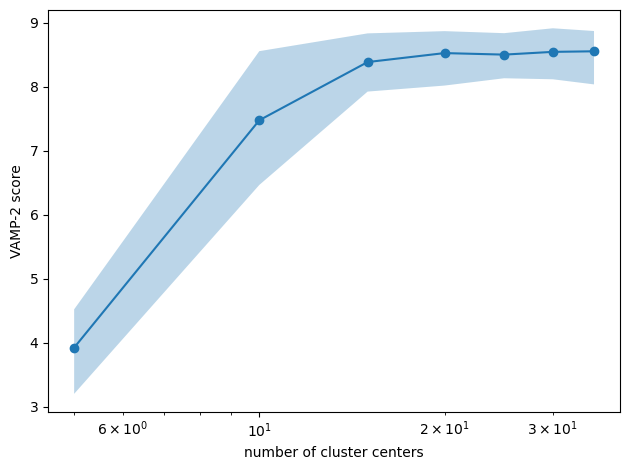

In [19]:
#previosly we chose lag time of 10 ns
n_clustercenters = [5, 10, 15, 20, 25, 30, 35]

scores = np.zeros((len(n_clustercenters), 100))
for n, k in enumerate(n_clustercenters):
    for m in range(100):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output_tor_ca, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 100)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()
plt.savefig('VAMP2 score|num of cluster centers - tor_ca', dpi=300)
plt.savefig('VAMP2 score|num of cluster centers - tor_ca.pdf', dpi=300)

In [20]:
#20 cluster centers
cluster_tor_ca = pyemma.coordinates.cluster_kmeans(
    tica_output_tor_ca, k=20, max_iter=50, stride=10, fixed_seed=False)
dtrajs_concatenated_tor_ca = np.concatenate(cluster_tor_ca.dtrajs)

/Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/erollab/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/20 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                | 0/10 [00:00<?, ?it/s]

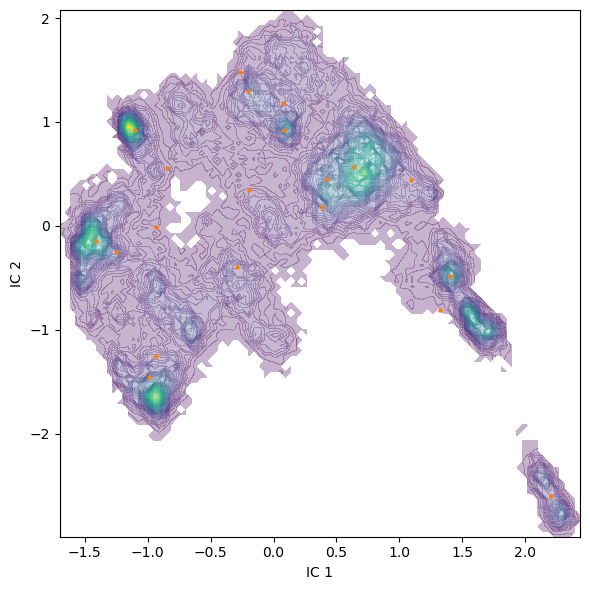

In [21]:
#20 cluster centers
fig, ax = plt.subplots(figsize=(6, 6))
pyemma.plots.plot_density(
    *tica_concatenated_tor_ca[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster_tor_ca.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.savefig('centers on the TICA dimensions - tor_ca - 20 centers', dpi=300)
plt.savefig('centers on the TICA dimensions - tor_ca - 20 centers.pdf', dpi=300)

In [22]:
cluster_tor_ca

KmeansClustering(clustercenters=array([[-2.68342e-01,  1.47592e+00, ..., -9.95474e-03, -1.22209e-02],
       [-9.29511e-01, -1.25407e+00, ...,  6.79224e-03, -1.65480e-02],
       ...,
       [-1.99677e-01,  1.29685e+00, ...,  1.45576e-02,  2.11920e-04],
       [ 8.72107e-02,  9.25378e-01, ..., -1.31678e-02, -9.06057e-03]],
      dtype=float32),
         fixed_seed=1949337371, init_strategy='kmeans++', keep_data=False,
         max_iter=50, metric='euclidean', n_clusters=20, n_jobs=8,
         oom_strategy='memmap', skip=0, stride=10, tolerance=1e-05)

### MSM estimation and validation 

### Implied timescales

estimating BayesianMSM:   0%|                            | 0/13 [00:00<?, ?it/s]

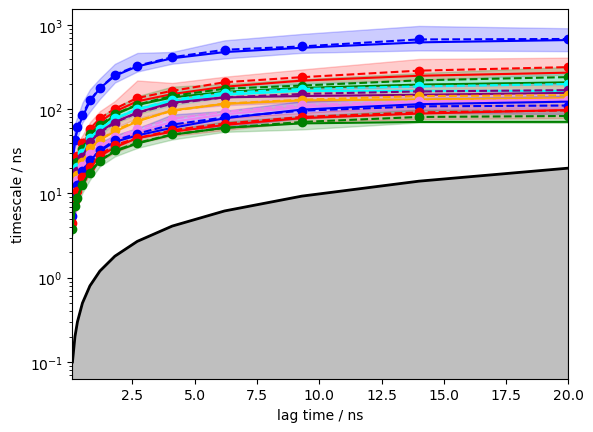

In [26]:
its_tor_ca = pyemma.msm.its(cluster_tor_ca.dtrajs, lags=200, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its_tor_ca, units='ns', dt=0.1);
plt.savefig('ITS - tor_ca - 20 cluster centers', dpi=300)
plt.savefig('ITS - tor_ca - 20 cluster centers.pdf', dpi=300)

### I think 7 ns is the best lag time!

In [44]:
#I'm going for lag time of 7 ns from this point onward
msm_tor_ca = pyemma.msm.bayesian_markov_model(cluster_tor_ca.dtrajs, lag=70, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm_tor_ca.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm_tor_ca.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[2834]: Sampling MSMs:   0%| | 0/1

fraction of states used = 0.95
fraction of counts used = 0.97


The information used is not perfect but it's not that bad either?

In [45]:
msm_tor_ca

BayesianMSM(conf=0.95, connectivity='largest', core_set=None,
      count_mode='effective', dt_traj='0.1 ns', lag=70,
      milestoning_method='last_core', mincount_connectivity='1/n',
      nsamples=100, nsteps=4, reversible=True, show_progress=True,
      sparse=False, statdist_constraint=None)

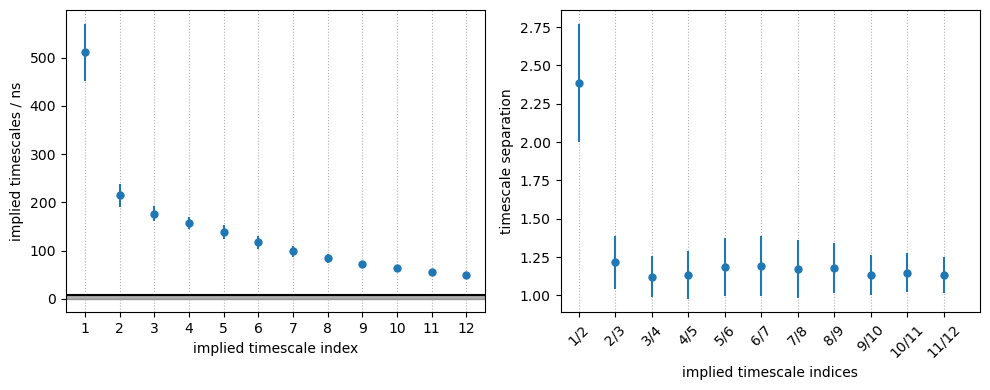

In [46]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 12

timescales_mean_tor_ca = msm_tor_ca.sample_mean('timescales', k=nits)
timescales_std_tor_ca = msm_tor_ca.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean_tor_ca,
    yerr=timescales_std_tor_ca,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean_tor_ca[:-1] / timescales_mean_tor_ca[1:],
    yerr=its_separation_err(
        timescales_mean_tor_ca,
        timescales_std_tor_ca),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm_tor_ca.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm_tor_ca.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('examining the implied timescales - tor_ca - lag 7 ns', dpi=300)
# plt.savefig('examining the implied timescales - tor_ca - lag 7 ns.pdf', dpi=300)

2 states for sure!

### Chapman-Kolmogorov test

estimating BayesianMSM:   0%|                             | 0/5 [00:00<?, ?it/s]

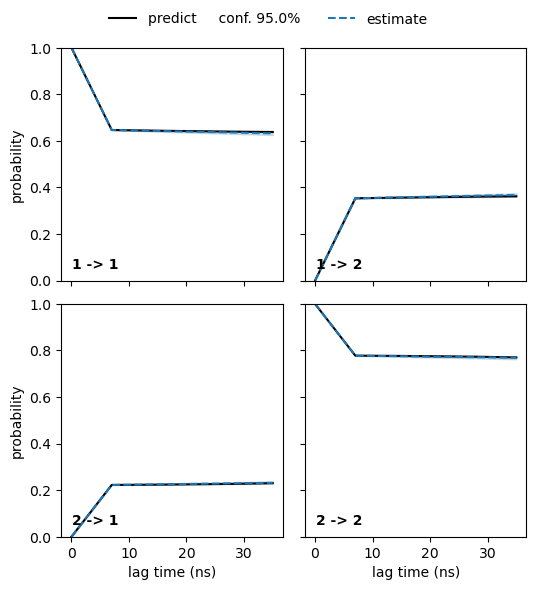

In [47]:
#2 states
nstates_tor_ca = 2
cktest_tor_ca = msm_tor_ca.cktest(nstates_tor_ca, mlags=6)
pyemma.plots.plot_cktest(cktest_tor_ca, dt=0.1, units='ns');
# plt.savefig('Chapman-Kolmogorov test - tor_ca - 3 states', dpi=300)
# plt.savefig('Chapman-Kolmogorov test - tor_ca - 3 states.pdf', dpi=300)

CK test passes

IndexError: index 19 is out of bounds for axis 0 with size 19

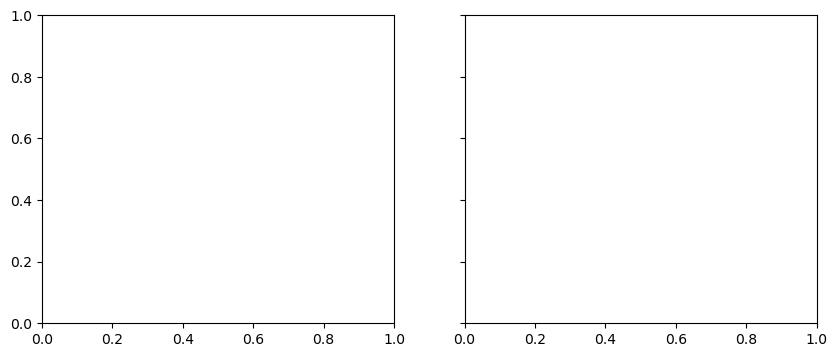

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated_tor_ca[:, :2].T,
    msm_tor_ca.pi[dtrajs_concatenated_tor_ca],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated_tor_ca[:, :2].T,
    weights_tor_ca=np.concatenate(msm_tor_ca.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
plt.savefig('stationary distribution & the free energy - tor_ca', dpi=300)
plt.savefig('stationary distribution & the free energy - tor_ca.pdf', dpi=300)

### Perron cluster cluster analysis

In [ ]:
#3 states
msm_tor_ca.pcca(nstates_tor_ca)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated_tor_ca[:, :2].T,
        msm_tor_ca.metastable_distributions[i][dtrajs_concatenated_tor_ca],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()
plt.savefig('PCCA++ membership - tor_ca - for 3 states', dpi=300)
plt.savefig('PCCA++ membership - tor_ca - for 3 states.pdf', dpi=300)

In [ ]:
metastable_traj_tor_ca = msm_tor_ca.metastable_assignments[dtrajs_concatenated_tor_ca]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated_tor_ca[:, :2].T, metastable_traj_tor_ca, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates_tor_ca)])
fig.tight_layout()
plt.savefig('PCCA++ on TICA progection - tor_ca - 3 states', dpi=300)
plt.savefig('PCCA++ on TICA progection - tor_ca - 3 states.pdf', dpi=300)

In [ ]:
pcca_samples_tor_ca = msm_tor_ca.sample_by_distributions(msm_tor_ca.metastable_distributions, 10)
tor_ca_source = pyemma.coordinates.source(files, features=tor_ca_feat)
pyemma.coordinates.save_trajs(
    tor_ca_source,
    pcca_samples_tor_ca,
    outfiles=['./pcca{}_tor_ca_10samples_2nd_try_3states.pdb'.format(n + 1)
              for n in range(msm_tor_ca.n_metastable)])

In [ ]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm_tor_ca.metastable_sets):
    p_tor_ca = msm_tor_ca.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p_tor_ca, -np.log(p_tor_ca)))

In [ ]:
from itertools import product

mfpt_tor_ca = np.zeros((nstates_tor_ca, nstates_tor_ca))
for i, j in product(range(nstates_tor_ca), repeat=2):
    mfpt_tor_ca[i, j] = msm_tor_ca.mfpt(
        msm_tor_ca.metastable_sets[i],
        msm_tor_ca.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt_tor_ca, decimals=2), index=range(1, nstates_tor_ca + 1), columns=range(1, nstates_tor_ca + 1))

***